# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import imgaug
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

MODEL_NAME = "unet_weights.labeloverlaystepbig.best.hdf5"
OVERWRITE = False
CPU_COUNT = int(multiprocessing.cpu_count()/4)
TRAINCSV = "train.csv"
WORK_DIR = "../../../../"
DATA_DIR = os.path.join(WORK_DIR,'1k')
LABEL_DIR = os.path.join(DATA_DIR,'train_label_overlay')
TEST_DIR = os.path.join(DATA_DIR,'test')
LABTEST_DIR = os.path.join(DATA_DIR,'test_label')
MODEL_DIR = os.path.join(DATA_DIR,'model')
USE_CV2 = False
LABEL_MAP = {0:'others',
            1:'rover',
            17:'sky',
            33:'car',
            34:'motorbicycle',
            35:'bicycle',
            36:'person',
            37:'rider',
            38:'truck',
            39:'bus',
            40:'tricycle',
            49:'road',
            50:'siderwalk',
            65:'traffic_cone',
            66:'road_pile',
            67:'fence',
            81:'traffic_light',
            82:'pole',
            83:'traffic_sign',
            84:'wall',
            85:'dustbin',
            86:'billboard',
            97:'building',
            98:'bridge',
            99:'tunnel',
            100:'overpass',
            113:'vegatation',
            161:'car_groups',
            162:'motorbicycle_group',
            163:'bicycle_group',
            164:'person_group',
            165:'rider_group',
            166:'truck_group',
            167:'bus_group',
            168:'tricycle_group'}

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if os.name == 'nt':
    SPLIT_STR = '\\'
else:
    SPLIT_STR = '/'

if USE_CV2:
    import cv2
    cv2.setUseOptimized(True)
    from cv2 import imread
    MIN_OBJ_VAL = 1000
else:
    from skimage.io import imread
    MIN_OBJ_VAL = 1000

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\ahmad\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class CVPRConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cvpr"
    BACKBONE = "resnet50"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + int(len(LABEL_MAP))  # background + nuclei

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50
    
config = CVPRConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                48
IMAGE_MIN_DIM                  512
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cvpr
NUM_CLASSES                    36
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NM

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
import ast, os, cv2, skimage.io, skimage.color, skimage.transform
import pandas as pd
import numpy as np
from mrcnn import utils

_MODEL = "RCNN"
_WORKPATH = os.getcwd()
_ROOTDIR = os.path.abspath("../../../")
_TRAINCSV = os.path.join(_WORKPATH, _ROOTDIR,'EyeAware','trainlog.csv')
_TRAINPATH = os.path.join(_WORKPATH, _ROOTDIR,'EyeAware')
print(_TRAINCSV)


class CVPRDataset(utils.Dataset):

    def load_cvpr(self, height, width, aug=False):
    #Pre-augment data disable
        for numclass in LABEL_MAP:
            self.add_class("cvpr",int(numclass),LABEL_MAP[numclass])
        
        traindf = pd.read_csv(_TRAINCSV)

        for i,imgid in enumerate(traindf['imageid']):
            self.add_image("cvpr", image_id=i, path=str(os.path.join(_TRAINPATH,traindf['image'].loc[i])), 
                           width=traindf['width'].loc[i], height=traindf['height'].loc[i],
                           maskpath=str(os.path.join(_TRAINPATH,traindf['label'].loc[i])))

    def image_reference(self, image_id):
        
        info = self.image_info[image_id]
        if info["source"] == "cvpr":
            return ""
        else:
            super(self.__class__).image_reference(image_id)

    def load_mask(self, image_id, size=None):
        
        class_ids = []
        info = self.image_info[image_id]
        mask_path = info['maskpath']
        premask = imread(mask_path, cv2.IMREAD_ANYDEPTH) if USE_CV2 else imread(mask_path)
        mask_classes_nc = np.unique(premask)
        mask = np.zeros((info['height'],info['width'],len(mask_classes_nc)),dtype=np.uint8)
        for layer,tempmask in enumerate(mask_classes_nc):
            modifymask = imread(mask_path, cv2.IMREAD_ANYDEPTH) if USE_CV2 else imread(mask_path)
            modifymask[modifymask != tempmask] = 0
            mask[:,:,layer] = modifymask
        mask_classes = mask_classes_nc//1000
        for i in mask_classes:
            if i == 0:
                class_ids.append((list(LABEL_MAP).index(i)))
            else:
                class_ids.append((list(LABEL_MAP).index(i))+1)
        #mask = mask[:, :, np.newaxis]
        class_ids = np.array(class_ids)
        return mask.astype(np.bool), class_ids.astype(np.int32)

Z:\ML\EyeAware\trainlog.csv


In [5]:
# Training dataset
dataset_train = CVPRDataset()
dataset_train.load_cvpr(config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = CVPRDataset()
dataset_val.load_cvpr(config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

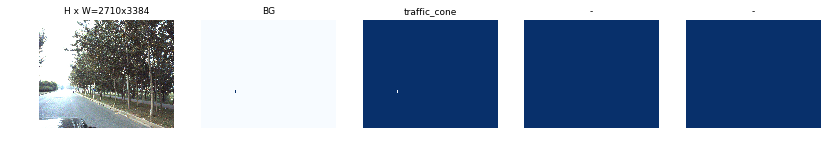

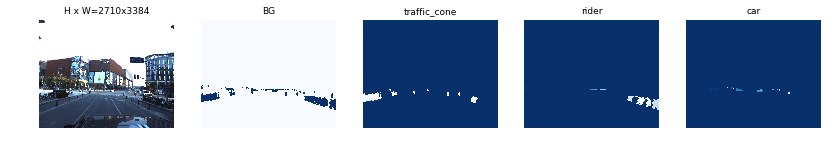

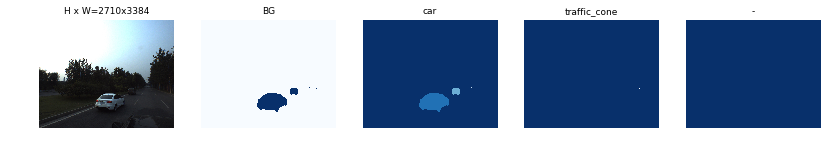

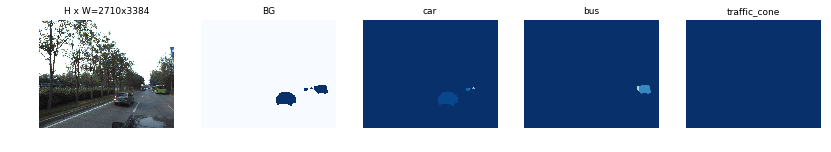

In [6]:
# Load and display random samples
np.set_printoptions(threshold=50)
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,4)

## Ceate Model

In [7]:
# Create model in training mode
_MODELPATH = os.path.join(_WORKPATH, _ROOTDIR,'CVPR','model')
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=_MODELPATH)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last
model_path = os.path.join(_MODELPATH, "mrcnn_cvpr_aug10e512x")
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)
    
elif init_with == "saved":
    model.load_weights(model_path, by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads',
            augmentation = imgaug.augmenters.Sometimes(0.5, [imgaug.augmenters.Fliplr(0.5),imgaug.augmenters.GaussianBlur(sigma=(0.0, 2.0)),imgaug.augmenters.Flipud(0.15),imgaug.augmenters.Dropout(p=(0, 0.05)), imgaug.augmenters.Affine(rotate=(0, 45))]))
#

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all",
            augmentation = imgaug.augmenters.Sometimes(0.5, [imgaug.augmenters.Fliplr(0.5),imgaug.augmenters.GaussianBlur(sigma=(0.0, 2.3)),imgaug.augmenters.Flipud(0.15),imgaug.augmenters.Dropout(p=(0, 0.08)), imgaug.augmenters.Affine(rotate=(0, 45))]))


Starting at epoch 0. LR=0.0001

Checkpoint Path: Z:\ML\CVPR\model\cvpr20180521T1649\mask_rcnn_cvpr_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          

C:\Users\ahmad\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
 630/1000 [=================>............] - ETA: 4:10:00 - loss: 3.3423 - rpn_class_loss: 0.1499 - rpn_bbox_loss: 1.6051 - mrcnn_class_loss: 0.2755 - mrcnn_bbox_loss: 0.6165 - mrcnn_mask_loss: 0.6953

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(_MODELPATH, "mrcnn_cvpr_aug10e512x1000s")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(CVPRConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=model_path)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()[1]
#model_path = os.path.join(MODEL_DIR, "mask_rcnn_256r50e8b.h5")
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)

#TEST
image = dataset_val.load_image(image_id)
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(det_count, np.array(dataset_val.class_names)[det_class_ids]))

det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c]
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
print("shape ; {}".format(det_masks.shape))
finalresult=np.expand_dims(modellib.mold_image(image, inference_config), 0)

#TEST

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


plt.imsave(fname= "ori.png", arr = original_image)
#plt.imsave(fname= "meta.png", arr = gt_mask)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))